In [2]:
# import basic libraries
import os
import json
import numpy as np
import pandas as pd
import re
import random
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import Counter
import plotly.io as pio
import pyperclip
from sklearn.cluster import KMeans
import importlib.util
from pathlib import Path

In [2]:
from transformers import AutoModel, AutoTokenizer
from transformers import PreTrainedTokenizer
from tensor2tensor.data_generators import text_encoder

In [16]:
base_path = "/srv/models/latin-bert"

# Initialize the tokenizer with the vocab.txt file and the encoder
vocab_file_path = "/srv/models/latin-bert/vocab.txt" # "/Users/vojtechkase/Projects/latin-bert/models/latin_bert/vocab.txt"  # Update this path
subword_tokenizer_path = "/srv/models/latin-bert/latin.subword.encoder"
# Update this path
encoder = text_encoder.SubwordTextEncoder(subword_tokenizer_path)

spec = importlib.util.spec_from_file_location("latin_tokenizer", os.path.join(base_path, "latin_tokenizer.py"))
latin_tokenizer_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(latin_tokenizer_module)
LatinTokenizer = latin_tokenizer_module.LatinTokenizer

tokenizer = LatinTokenizer(vocab_file_path, encoder)

model = AutoModel.from_pretrained(base_path)

In [17]:
# Check if GPU is availableš
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to GPU
# model = model.to(device)

Explore how our bert tokenize a sentence.

In [19]:
sent = "Scientia et cognitio naturae principia universi detegunt et humanum ingenium illuminant."
sent = sent.lower()
input_ids = tokenizer.encode(sent)
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)

['scientia_', 'et', 'cognitio_', 'naturae_', 'principia_', 'universi_', 'deteg', 'unt_', 'et', 'humanum_', 'ingenium_', 'illuminan', 't_', '._']


In [20]:
inputs = tokenizer(sent, return_tensors='pt', padding=True, truncation=True, max_length=512, return_offsets_mapping=True)
input_ids = inputs['input_ids']
input_ids[0][:20] #bert_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

tensor([ 1104,  3356,  1375,   601,  2440,  5737, 21416,   105,  3356,  3138,
         4560, 29394,    29,     8,     0,     0,     0,     0,     0,     0])

# Loading and processing Noscemus textual data

In [21]:
metadata_table_long = pd.read_json("https://raw.githubusercontent.com/CCS-ZCU/noscemus_ETF/master/data/metadata_table_long.json")
# or, if you have noscemus_ETF repository somewhere....
metadata_table_long.head(5)

Author                                         Full title  \
0  Achrelius, Daniel  Scientiarum magnes recitatus publice anno 1690...   
1  Acidalius, Valens                 Ad Iordanum Brunum Nolanum, Italum   
2    Acosta, José de  De natura novi orbis libri duo et De promulgat...   
3     Adam, Melchior  Vitae Germanorum medicorum, qui saeculo superi...   
4    Addison, Joseph  Ad insignissimum virum dominum Thomam Burnettu...   

                                                  In  Year              Place  \
0                                               None  1690            [Turku]   
1  Poematum Iani Lernutii, Iani Gulielmi, Valenti...  1603  Liegnitz, Wrocław   
2                                               None  1589          Salamanca   
3                                               None  1620         Heidelberg   
4  Examen poeticum duplex, sive, Musarum anglican...  1698             London   

       Publisher/Printer           Era      Form/Genre  \
0                   Wall  17th century         Oration   
1          Albert, David  17th century  Panegyric poem   
2       Guillelum Foquel  16th century       Monograph   
3           Rosa, Geyder  17th century       Biography   
4  Richard Wellington I.  17th century  Panegyric poem   

                                  Discipline/Content  \
0  Mathematics, Astronomy/Astrology/Cosmography, ...   
1                    Astronomy/Astrology/Cosmography   
2  Astronomy/Astrology/Cosmography, Geography/Car...   
3                                           Medicine   
4                         Meteorology/Earth sciences   

                                            Original  ...       ids      id  \
0                   Scientiarum magnes(Google Books)  ...  [705665]  705665   
1  Ad Iordanum Brunum (1603)(CAMENA)Ad Iordanum B...  ...  [801745]  801745   
2  De natura novi orbis(Biodiversity Heritage Lib...  ...  [713323]  713323   
3  Vitae Germanorum medicorum(MDZ)Alternative lin...  ...  [693148]  693148   
4  Ad Burnettum sacrae theoriae telluris auctorem...  ...  [769230]  769230   

  date_min date_max                                           filename  \
0   1690.0   1690.0  Achrelius,_Daniel_-_Scientiarum_magnes__Turku_...   
1   1603.0   1603.0  Janus_Lernutius_et_al__-_Poemata__Liegnitz_160...   
2   1589.0   1589.0  Acosta,_José_de_-_De_natura_novi_orbis__Salama...   
3   1620.0   1620.0  Adam,_Melchior_-_Vitae_Germanorum_medicorum__H...   
4   1698.0   1698.0        Examen_poeticum_duplex__London_1698_pdf.txt   

  file_year sents_n tokens_n  \
0    1690.0     630     8839   
1    1603.0    6527    82445   
2    1589.0    8905   170205   
3    1620.0   17961   193272   
4    1698.0    3533    47878   

                                    disciplines_list   science_class  
0  [Mathematics, Astronomy/Astrology/Cosmography,...         mixture  
1                  [Astronomy/Astrology/Cosmography]  exact_sciences  
2  [Astronomy/Astrology/Cosmography, Geography/Ca...  exact_sciences  
3                                         [Medicine]   life_sciences  
4                       [Meteorology/Earth sciences]  exact_sciences  

[5 rows x 30 columns]

In [32]:
metadata_table_long[metadata_table_long["Author"].str.contains("Galileo")]

Author  \
333                      Galilei, Galileo   
334                      Galilei, Galileo   
335  Galilei, Galileo,Bernegger, Matthias   

                                            Full title  \
333  Sidereus nuntius magna longeque admirabilia sp...   
334                                            De motu   
335  Systema cosmicum authore Galilaeo Galilaei Lyn...   

                           In  Year       Place            Publisher/Printer  \
333                      None  1610      Venice                     Baglioni   
334  See below, "References".  None        None                         None   
335                      None  1635  Strasbourg  Officina Elzeviriana, Hautt   

              Era                       Form/Genre  \
333  17th century  Report, Other (see description)   
334  16th century              Monograph, Dialogue   
335  17th century                         Dialogue   

                                    Discipline/Content  \
333  Mathematics, Astronomy/Astrology/Cosmography, ...   
334                                            Physics   
335  Physics, Astronomy/Astrology/Cosmography, Mete...   

                                              Original  ...       ids      id  \
333  Sidereus nuntius(e-rara.ch)Alternative links:W...  ...  [888526]  888526   
334                               De motu(archive.org)  ...  [668497]  668497   
335                     Systema cosmicum(Google Books)  ...  [733507]  733507   

    date_min date_max                                           filename  \
333   1610.0   1610.0  Galilei,_Galileo_-_Sidereus_nuntius__Venice_16...   
334      NaN      NaN  Favaro,_Antono_(ed_)_-_Le_opere_di_Galileo_Gal...   
335   1635.0   1635.0  Galilei,_Galileo_&_Bernegger,_Matthias_-_Syste...   

    file_year sents_n tokens_n  \
333    1610.0     965    13251   
334    1890.0    4950    79183   
335    1635.0   13805   215467   

                                      disciplines_list   science_class  
333  [Mathematics, Astronomy/Astrology/Cosmography,...  exact_sciences  
334                                          [Physics]  exact_sciences  
335  [Physics, Astronomy/Astrology/Cosmography, Met...  exact_sciences  

[3 rows x 30 columns]

In [36]:
id = 888526
path="/srv/data/tome/noscemus/sents_data/"
os.listdir(path)[:10]

['725075.pickle',
 '928138.pickle',
 '985903.pickle',
 '733505.pickle',
 '739101.pickle',
 '702145.pickle',
 '906214.pickle',
 '902259.pickle',
 '901017.pickle',
 '904418.pickle']

In [ ]:
sents_data = pickle.load(open(path + str(id) + ".pickle", "rb"))
sents_data[100:105]

[('commode enim id fieri licet uno eodemque tempore oculis ambobus adapertis;',
  [('commode', 'commodus', 'ADV', (0, 7)),
   ('enim', 'enim', 'PART', (8, 12)),
   ('id', 'is', 'PRON', (13, 15)),
   ('fieri', 'fio', 'VERB', (16, 21)),
   ('licet', 'licet', 'SCONJ', (22, 27)),
   ('uno', 'unus', 'NUM', (28, 31)),
   ('eodem', 'idem', 'DET', (32, 37)),
   ('que', 'que', 'CCONJ', (37, 40)),
   ('tempore', 'tempus', 'NOUN', (41, 48)),
   ('oculis', 'oculus', 'NOUN', (49, 55)),
   ('ambobus', 'ambo', 'DET', (56, 63)),
   ('adapertis', 'adaperio', 'VERB', (64, 73)),
   (';', ';', 'PUNCT', (73, 74))]),
 ('tunc enim figurae ambae eiusdem apparebunt magnitudinis, si Organum secundum optatam proportionem obiecta multiplicauerit.',
  [('tunc', 'tunc', 'ADV', (0, 4)),
   ('enim', 'enim', 'PART', (5, 9)),
   ('figurae', 'figura', 'NOUN', (10, 17)),
   ('ambae', 'ambo', 'DET', (18, 23)),
   ('eiusdem', 'idem', 'DET', (24, 31)),
   ('apparebunt', 'appareo', 'VERB', (32, 42)),
   ('magnitudinis', 'mag

In [40]:
# filter ids by date
# extract ids of works from certain interval
ids = metadata_table_long[metadata_table_long["file_year"].between(1590, 1610)]["id"].tolist()
ids[:10]

[801745,
 599723,
 767766,
 1424044,
 658379,
 731624,
 804026,
 668493,
 928888,
 888129]

In [41]:
len(ids)

53

In [ ]:
sents_data_merged = []
for id in ids:
    sents_data = pickle.load(open(path + str(id) + ".pickle", "rb"))
    sents_data_merged.extend(sents_data)

In [22]:
id_year_dict = dict(zip(metadata_table_long["id"].astype(str), metadata_table_long["file_year"]))

In [23]:
id_author_dict = dict(zip(metadata_table_long["id"].astype(str), metadata_table_long["Author"].apply(lambda x: x.partition(",")[0])))

## Working with target sentences

In [24]:
def get_sentence_data(target_lemma, path="/srv/data/tome/noscemus/sents_data/"):
    target_sentences = []  
    fns = os.listdir(path)
    for fn in fns:
        sents_data = pickle.load(open(path + fn, "rb"))
        for sent_n, (sent_text, sent_data) in enumerate(sents_data):
            lemmata = [tup[1] for tup in sent_data]
            if target_lemma in lemmata:
                sent_data = sents_data[sent_n]
                target_sentences.append((fn, sent_n, sent_data[0], sent_data[1]))
    return target_sentences

In [27]:
%%time
tar_sents = get_sentence_data("liber")

CPU times: user 1min 36s, sys: 784 ms, total: 1min 37s
Wall time: 1min 37s


In [28]:
len(tar_sents)

181019

In [29]:
sents_meta = [sent_data for sent_data in tar_sents if re.search(r"lib\w{2,3} natura",  sent_data[2])]
sents_meta[:5]

[('704336.pickle',
  29989,
  'omnes hi cum lanne & Mambre et Simone mago aeternis ignibus cruciandi destinabuntur. 99 In primo libro naturalis magia traditur, quae multa sane cognitu pulchra & iucun da lectu continet:',
  [('omnes', 'omnis', 'DET', (0, 5)),
   ('hi', 'hic', 'DET', (6, 8)),
   ('cum', 'cum', 'ADP', (9, 12)),
   ('lanne', '', 'NOUN', (13, 18)),
   ('&', '&', 'PUNCT', (19, 20)),
   ('Mambre', '', 'PROPN', (21, 27)),
   ('et', 'et', 'CCONJ', (28, 30)),
   ('Simone', 'Simo', 'PROPN', (31, 37)),
   ('mago', 'magus', 'NOUN', (38, 42)),
   ('aeternis', 'aeternus', 'ADJ', (43, 51)),
   ('ignibus', 'ignis', 'NOUN', (52, 59)),
   ('cruciandi', 'crucio', 'VERB', (60, 69)),
   ('destinabuntur', 'destino', 'VERB', (70, 83)),
   ('.', '.', 'PUNCT', (83, 84)),
   ('99', '99', 'NUM', (85, 87)),
   ('In', 'in', 'ADP', (88, 90)),
   ('primo', 'primus', 'ADJ', (91, 96)),
   ('libro', 'liber', 'NOUN', (97, 102)),
   ('naturalis', 'naturalis', 'ADJ', (103, 112)),
   ('magia', 'magia', 'NOU

In [30]:
len(sents_meta)

154

In [22]:
with open("../data/liber_sents_data.json", "w") as f:
    json.dump(sents_meta, f)

# Generating embeddings

In [23]:
def get_decontextualized_embeddings(word: str):
    input_ids = tokenizer.encode(word) # , add_special_tokens=False)
    input_ids_tensor = torch.LongTensor(input_ids).to(device)  # Move to GPU
    word_emb = model.get_input_embeddings()
    embeddings = word_emb(input_ids_tensor)
    return embeddings.mean(0).cpu().detach().numpy()

def compute_offsets(text, tokens):
    """
    Compute character offsets for each token in the original text.
    """
    offsets = []
    current_pos = 0
    for token in tokens:
        # Handle leading spaces and special characters
        token = token.replace("Ġ", "")
        start_idx = text.find(token, current_pos)
        if start_idx == -1:
            # Token not found, possibly a split token or special case
            # Attempt to find token by removing special characters
            cleaned_token = token.replace('_', '')
            start_idx = text.find(cleaned_token, current_pos)
            if start_idx != -1:
                end_idx = start_idx + len(cleaned_token)
                offsets.append((start_idx, end_idx))
                current_pos = end_idx
            else:
                # If still not found, append a dummy offset
                offsets.append((current_pos, current_pos + len(token)))
        else:
            end_idx = start_idx + len(token)
            offsets.append((start_idx, end_idx))
            current_pos = end_idx

    return offsets
    
def get_embeddings_data(sent, tokenized_data):
    sent = sent.lower()
    # Tokenize and prepare input tensors
    inputs = tokenizer(sent, return_tensors='pt', padding=True, truncation=True, max_length=512) #return_offsets_mapping=True)

    input_ids_tensor = inputs['input_ids'].to(device)  # Move to GPU
    attention_mask_tensor = inputs.get('attention_mask', torch.ones_like(input_ids_tensor)).to(device)  # Move to GPU

    # Convert input IDs to tokens
    bert_tokens = tokenizer.convert_ids_to_tokens(input_ids_tensor[0].tolist())
    offset_mapping = compute_offsets(sent, bert_tokens)

    # Model forward pass
    with torch.no_grad():
        outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
        last_hidden_state = outputs.last_hidden_state
        bert_sentence_embeddings = last_hidden_state.mean(dim=1).squeeze().cpu().detach().numpy()  # Move back to CPU
        bert_token_embeddings = last_hidden_state[0].cpu().detach().numpy()  # Move back to CPU

    # Prepare tokens data for comparison
    tokens_data_updated = [(token, offset, embedding) for token, offset, embedding in zip(bert_tokens, offset_mapping, bert_token_embeddings)]

    covered_tups = []
    for word_tuple in tokenized_data:
        start_offset, end_offset = word_tuple[-1]
    
        # Extract covered tokens and embeddings
        covered_tokens = [tup[0] for tup in tokens_data_updated if start_offset <= tup[1][0] < end_offset]
        covered_embeddings = [tup[2] for tup in tokens_data_updated if start_offset <= tup[1][0] < end_offset]
    
        # Compute average embedding
        if covered_embeddings:
            embedding_avg = np.mean(covered_embeddings, axis=0)
        else:
            embedding_avg = np.zeros(768)
    
        # Decontextualized embedding
        embedding_decontext = get_decontextualized_embeddings(word_tuple[0])
    
        # Compute similarity score
        embedding_avg_2d = embedding_avg.reshape(1, -1)
        embedding_decontext_2d = embedding_decontext.reshape(1, -1)
        if np.isnan(embedding_avg).any() or np.isnan(embedding_decontext).any():
            similarity_score = None
        else:
            similarity_score = cosine_similarity(embedding_avg_2d, embedding_decontext_2d)[0, 0]
    
        # Append to results
        covered_tups.append((
            word_tuple[0],    # spacy_tokens
            word_tuple[1],    # spacy_lemma
            word_tuple[2],    # spacy_pos
            word_tuple[3],    # spacy_position
            covered_tokens,   # bert_tokens
            covered_embeddings, # bert_tok_emb
            embedding_avg.tolist(),   # Convert numpy array to list
            embedding_decontext.tolist(), # Convert numpy array to list
            similarity_score # cos_sim
        ))
    
    # Create DataFrame
    df = pd.DataFrame(covered_tups, columns=[
        "spacy_tokens", "spacy_lemma", "spacy_pos", "spacy_position",
        "bert_tokens", "bert_tok_emb", "bert_avg_emb", "bert_avg_decontext", "cos_sim"
    ])

    return bert_sentence_embeddings, df

In [24]:
sent_n = 8
sent = sents_meta[sent_n][2].lower()
tokenized_data = sents_meta[sent_n][3]
sent

'formarum autem seu imaginum, quas ciere duo imaginum intus anima solet, duo promptuaria esse libro naturalium sexto auicenna tradit, thesauros formarum uocans:'

In [25]:
inputs = tokenizer(sent, return_tensors='pt', padding=True, truncation=True, max_length=512) #return_offsets_mapping=True)
inputs

{'input_ids': tensor([[26026, 29372,  4693, 19351,    27,     7,  5998,  4547,    59, 12911,
          19351,    27,  2069,  5544,  1246,     7, 12911, 20453,  2286,  3511,
            651, 18070,  3607,  4181,  4143,   328,  4906,     7, 13062,    14,
          26026,  8262,   118,    17,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,    

In [26]:
input_ids = tokenizer.encode(sent)
tokens = tokenizer.convert_ids_to_tokens(input_ids)
tokens

['formarum_',
 'autem',
 'seu',
 'imagin',
 'um_',
 ',_',
 'quas',
 'cie',
 're_',
 'duo',
 'imagin',
 'um_',
 'intus_',
 'anima',
 'solet_',
 ',_',
 'duo',
 'promptu',
 'aria_',
 'esse',
 'libro_',
 'naturalium_',
 'sexto_',
 'aui',
 'cen',
 'na_',
 'tradit_',
 ',_',
 'thesauro',
 's_',
 'formarum_',
 'uoca',
 'ns_',
 ':_']

In [30]:
sentence_emb, df = get_embeddings_data(sent.lower(), tokenized_data)
df

spacy_tokens   spacy_lemma spacy_pos spacy_position       bert_tokens  \
0      Formarum         forma      NOUN         (0, 8)       [formarum_]   
1         autem         autem      PART        (9, 14)           [autem]   
2           seu          siue     CCONJ       (15, 18)             [seu]   
3      imaginum         imago      NOUN       (19, 27)     [imagin, um_]   
4             ,             ,     PUNCT       (27, 28)              [,_]   
5          quas           qui      PRON       (29, 33)            [quas]   
6         ciere           cio      VERB       (34, 39)        [cie, re_]   
7           Duo           duo       NUM       (40, 43)             [duo]   
8      imaginum         imago      NOUN       (44, 52)     [imagin, um_]   
9         intus         intus       ADV       (53, 58)          [intus_]   
10        anima         anima      NOUN       (59, 64)           [anima]   
11        solet         soleo      VERB       (65, 70)          [solet_]   
12            ,             ,     PUNCT       (70, 71)              [,_]   
13          duo           duo       NUM       (72, 75)             [duo]   
14  promptuaria  promptuarium       ADJ       (76, 87)  [promptu, aria_]   
15         esse           sum       AUX       (88, 92)            [esse]   
16        libro         liber      NOUN       (93, 98)          [libro_]   
17   naturalium     naturalis       ADJ      (99, 109)     [naturalium_]   
18        sexto        sextus       ADJ     (110, 115)          [sexto_]   
19     Auicenna      Auicenna     PROPN     (116, 124)   [aui, cen, na_]   
20       tradit         trado      VERB     (125, 131)         [tradit_]   
21            ,             ,     PUNCT     (131, 132)              [,_]   
22    thesauros     thesaurus      NOUN     (133, 142)    [thesauro, s_]   
23     formarum         forma      NOUN     (143, 151)       [formarum_]   
24       uocans          uoco      VERB     (152, 158)       [uoca, ns_]   
25            :             :     PUNCT     (158, 159)              [:_]   

                                         bert_tok_emb  \
0   [[-0.20829445, 0.031757616, -0.51340127, -1.04...   
1   [[-0.08150536, 0.23882027, -0.4995009, -0.9636...   
2   [[-0.28463143, 0.03610304, -0.5325649, -1.2378...   
3   [[-0.15180127, 0.17181236, -0.36701635, -1.088...   
4   [[-0.37807813, 0.08207306, -0.361526, -0.90419...   
5   [[-0.41710067, 0.22542909, -0.5227048, -0.7535...   
6   [[-0.3754464, 0.16404082, -0.22233184, -1.1980...   
7   [[-0.15817012, 0.20905748, -0.18637536, -0.845...   
8   [[-0.49140093, 0.14554639, -0.36095184, -1.180...   
9   [[-0.3340109, 0.057889864, -0.0776725, -0.5421...   
10  [[-0.025070291, 0.18948397, -0.17431818, -0.71...   
11  [[-0.47245476, -0.27516815, -0.85943365, -1.44...   
12  [[-0.3605473, -0.15427476, -0.42202824, -0.698...   
13  [[-0.29980308, 0.1381325, -0.19958794, -0.8958...   
14  [[-0.61794364, -0.17932701, -0.72700393, -1.38...   
15  [[-0.09836364, 0.09492554, -0.61459064, -1.131...   
16  [[-0.52429634, 0.24717401, -0.41121262, -0.779...   
17  [[-0.20981489, -0.059059683, -0.53161365, -0.9...   
18  [[-0.29517758, -0.43589994, -0.5125962, -0.443...   
19  [[-0.26423332, -0.20666045, -0.21085986, -0.83...   
20  [[-0.22114836, -0.041151777, -0.5561356, -0.92...   
21  [[-0.3158845, -0.15769586, -0.43010885, -0.564...   
22  [[-0.24598026, 0.1126837, 0.023931462, -0.5889...   
23  [[-0.3522618, 0.16209075, -0.006729298, -0.682...   
24  [[-0.54447603, 0.075613834, -0.023636835, -0.5...   
25  [[-0.3569095, -0.14166035, -0.53916824, -0.828...   

                                         bert_avg_emb  \
0   [-0.20829445123672485, 0.03175761550664902, -0...   
1   [-0.08150535821914673, 0.23882026970386505, -0...   
2   [-0.2846314311027527, 0.03610303997993469, -0....   
3   [-0.18889157474040985, -0.08048081398010254, -...   
4   [-0.3780781328678131, 0.08207306265830994, -0....   
5   [-0.4171006679534912, 0.22542908787727356, -0....   
6   [-0.421

In [31]:
n = 2000
tar_sents_sample = random.sample(tar_sents, n)

In [32]:
sents_meta[0]

('704336.pickle',
 29989,
 'omnes hi cum lanne & Mambre et Simone mago aeternis ignibus cruciandi destinabuntur. 99 In primo libro naturalis magia traditur, quae multa sane cognitu pulchra & iucun da lectu continet:',
 [('omnes', 'omnis', 'DET', (0, 5)),
  ('hi', 'hic', 'DET', (6, 8)),
  ('cum', 'cum', 'ADP', (9, 12)),
  ('lanne', '', 'NOUN', (13, 18)),
  ('&', '&', 'PUNCT', (19, 20)),
  ('Mambre', '', 'PROPN', (21, 27)),
  ('et', 'et', 'CCONJ', (28, 30)),
  ('Simone', 'Simo', 'PROPN', (31, 37)),
  ('mago', 'magus', 'NOUN', (38, 42)),
  ('aeternis', 'aeternus', 'ADJ', (43, 51)),
  ('ignibus', 'ignis', 'NOUN', (52, 59)),
  ('cruciandi', 'crucio', 'VERB', (60, 69)),
  ('destinabuntur', 'destino', 'VERB', (70, 83)),
  ('.', '.', 'PUNCT', (83, 84)),
  ('99', '99', 'NUM', (85, 87)),
  ('In', 'in', 'ADP', (88, 90)),
  ('primo', 'primus', 'ADJ', (91, 96)),
  ('libro', 'liber', 'NOUN', (97, 102)),
  ('naturalis', 'naturalis', 'ADJ', (103, 112)),
  ('magia', 'magia', 'NOUN', (113, 118)),
  ('tr

In [36]:
%%time
sents_dfs = []
for sent_data in sents_meta + tar_sents_sample:
    sent_emb, df = get_embeddings_data(sent_data[2], sent_data[3])
    sents_dfs.append((sent_data[0], sent_data[1], sent_data[2], sent_emb, df))

CPU times: user 43.1 s, sys: 1.51 s, total: 44.6 s
Wall time: 44.5 s


In [33]:
type(list(id_year_dict.keys())[0])

str

In [34]:
len(id_year_dict)

975

In [42]:
ids = [s[0].partition(".")[0] for s in sents_dfs]
years = [id_year_dict[id] if id in id_year_dict.keys() else None for id in ids]
years[:10]

[1545.0,
 1545.0,
 1545.0,
 1545.0,
 1548.0,
 1696.0,
 1530.0,
 1534.0,
 1522.0,
 1522.0]

In [43]:
authors = [id_author_dict[id] if id in id_author_dict.keys() else None for id in ids]
authors[:10]

['Gessner',
 'Gessner',
 'Gessner',
 'Gessner',
 'Gessner',
 'Baglivi',
 'Brunfels',
 'Brunfels',
 'Vadianus',
 'Vadianus']

In [44]:
sents_dfs[0][4]

spacy_tokens spacy_lemma spacy_pos spacy_position         bert_tokens  \
0           omnes       omnis       DET         (0, 5)            [omnes_]   
1              hi         hic       DET         (6, 8)                [hi]   
2             cum         cum       ADP        (9, 12)               [cum]   
3           lanne                  NOUN       (13, 18)          [lan, ne_]   
4               &           &     PUNCT       (19, 20)                 [&]   
5          Mambre                 PROPN       (21, 27)         [mam, bre_]   
6              et          et     CCONJ       (28, 30)                [et]   
7          Simone        Simo     PROPN       (31, 37)         [simo, ne_]   
8            mago       magus      NOUN       (38, 42)              [mago]   
9        aeternis    aeternus       ADJ       (43, 51)       [aeterni, s_]   
10        ignibus       ignis      NOUN       (52, 59)          [ignibus_]   
11      cruciandi      crucio      VERB       (60, 69)      [crucia, ndi_]   
12  destinabuntur     destino      VERB       (70, 83)  [destina, buntur_]   
13              .           .     PUNCT       (83, 84)                [._]   
14             99          99       NUM       (85, 87)                [99]   
15             In          in       ADP       (88, 90)                [in]   
16          primo      primus       ADJ       (91, 96)            [primo_]   
17          libro       liber      NOUN      (97, 102)            [libro_]   
18      naturalis   naturalis       ADJ     (103, 112)        [naturalis_]   
19          magia       magia      NOUN     (113, 118)          [magi, a_]   
20       traditur       trado      VERB     (119, 127)         [traditur_]   
21              ,           ,     PUNCT     (127, 128)                [,_]   
22           quae         qui      PRON     (129, 133)              [quae]   
23          multa      multus       DET     (134, 139)             [multa]   
24           sane        sane       ADV     (140, 144)             [sane_]   
25        cognitu    cognitus      NOUN     (145, 152)        [cognit, u_]   
26        pulchra     pulcher       ADJ     (153, 160)          [pulchra_]   
27              &           &     PUNCT     (161, 162)                 [&]   
28          iucun                   ADJ     (163, 168)          [iuc, un_]   
29             da          da       ADP     (169, 171)                [da]   
30          lectu        lego      NOUN     (172, 177)             [lectu]   
31       continet    contineo      VERB     (178, 186)         [continet_]   
32              :           :     PUNCT     (186, 187)                [:_]   

                                         bert_tok_emb  \
0   [[-0.2267545, 0.03534043, -0.57197773, -0.8987...   
1   [[0.065882646, 0.15884511, -0.29995036, -0.766...   
2   [[-0.078728326, 0.013177161, -0.32417047, -1.1...   
3   [[-0.5393002, 0.017649591, -0.66978925, -1.107...   
4   [[-0.098285615, 0.25577477, -0.37196028, -0.89...   
5   [[-0.11211276, 0.24862047, -0.40294325, -1.211...   
6   [[-0.18621594, 0.017778393, -0.23182139, -1.04...   
7   [[-0.5339989, 0.17992054, -0.07132285, -0.8835...   
8   [[-0.103658386, 0.119519696, -0.38165584, -0.6...   
9   [[-0.5825693, 0.15036915, -0.29319075, -1.0211...   
10  [[-0.2119685, -0.02800025, -0.33983883, -0.415...   
11  [[-0.40137362, -0.13304992, -0.36732808, -0.55...   
12  [[0.014151613, 0.14646553, 0.0009605256, -0.85...   
13  [[-0.21200058, -0.060892437, -0.79556954, -0.9...   
14  [[-0.16390304, 0.21782076, -0.3184218, -0.8634...   
15  [[-0.32377923, 0.13197023, -0.2877731, -1.3613...   
16  [[-0.41019115, -0.30939993, -0.41448352, -1.20...   
17  [[-0.500689, -0.06491266, -0.3863743, -0.60331...   
18  [[-0.41235715, 0.042038683, -0.13688312, -0.88...   
19  [[-0.31007752, -0.26242587, -0.21048287, -0.74...   
20  [[-0.45659456, 0.11957736, -0.10707189, -1.130...   
21  [[-0.4511241, -0.11871669, -0.27059343, -0.493...   
22  [[-0.35379595, 0.30774435, -0.2372686

In [45]:
sents_meta[0]

('704336.pickle',
 29989,
 'omnes hi cum lanne & Mambre et Simone mago aeternis ignibus cruciandi destinabuntur. 99 In primo libro naturalis magia traditur, quae multa sane cognitu pulchra & iucun da lectu continet:',
 [('omnes', 'omnis', 'DET', (0, 5)),
  ('hi', 'hic', 'DET', (6, 8)),
  ('cum', 'cum', 'ADP', (9, 12)),
  ('lanne', '', 'NOUN', (13, 18)),
  ('&', '&', 'PUNCT', (19, 20)),
  ('Mambre', '', 'PROPN', (21, 27)),
  ('et', 'et', 'CCONJ', (28, 30)),
  ('Simone', 'Simo', 'PROPN', (31, 37)),
  ('mago', 'magus', 'NOUN', (38, 42)),
  ('aeternis', 'aeternus', 'ADJ', (43, 51)),
  ('ignibus', 'ignis', 'NOUN', (52, 59)),
  ('cruciandi', 'crucio', 'VERB', (60, 69)),
  ('destinabuntur', 'destino', 'VERB', (70, 83)),
  ('.', '.', 'PUNCT', (83, 84)),
  ('99', '99', 'NUM', (85, 87)),
  ('In', 'in', 'ADP', (88, 90)),
  ('primo', 'primus', 'ADJ', (91, 96)),
  ('libro', 'liber', 'NOUN', (97, 102)),
  ('naturalis', 'naturalis', 'ADJ', (103, 112)),
  ('magia', 'magia', 'NOUN', (113, 118)),
  ('tr

In [46]:
sentences = [sent_data[2] for sent_data in sents_dfs]
sentences[:3]

['omnes hi cum lanne & Mambre et Simone mago aeternis ignibus cruciandi destinabuntur. 99 In primo libro naturalis magia traditur, quae multa sane cognitu pulchra & iucun da lectu continet:',
 'librum naturalis historiae, quo Catholicam syderum septem, aliaque astronomica & geographica toto sparsa opere tractauit, si quis uel aetate nostra, uel superiori enarrarit ignoro, &c. Post haec de antiqua astronomia Plinii disserit, & de uitiatis codicibus:',
 'Scholia quaedam in secundum C. Plinii librum naturalis historiae, impressa Basileae apud Hen.']

In [47]:
def insert_newlines(input_str, word_count=10):
    words = input_str.split(' ')
    for i in range(word_count - 1, len(words), word_count):
        words[i] = words[i] + '<br>'
    return ' '.join(words)

In [48]:
hover_text = [insert_newlines(sent) + " ({0} {1})".format(author, str(year)) for sent, author, year in zip(sentences, authors, years)]
print(hover_text[:10])

['omnes hi cum lanne & Mambre et Simone mago aeternis<br> ignibus cruciandi destinabuntur. 99 In primo libro naturalis magia traditur,<br> quae multa sane cognitu pulchra & iucun da lectu continet:<br> (Gessner 1545.0)', 'librum naturalis historiae, quo Catholicam syderum septem, aliaque astronomica &<br> geographica toto sparsa opere tractauit, si quis uel aetate nostra,<br> uel superiori enarrarit ignoro, &c. Post haec de antiqua astronomia<br> Plinii disserit, & de uitiatis codicibus: (Gessner 1545.0)', 'Scholia quaedam in secundum C. Plinii librum naturalis historiae, impressa<br> Basileae apud Hen. (Gessner 1545.0)', 'Ad utilitatem & salutem omnium Christianorum sequice tur scientia libri<br> creaturarum, siue libri naturae, & scientia de homine, quae est<br> proce pria homini in quantum homo est: (Gessner 1545.0)', 'tus liber, a Philippo Clerico ex Arabi De problematibus rerum,<br> Solinus, co in Latinum sermonem translatus De mirabilibus naturae Pub.<br> (Gessner 1548.0)', 'De m

In [49]:
sents_meta_df = pd.DataFrame([(fn.rpartition(".")[0], index, sent) for fn, index, sent, sent_data in sents_meta])

In [50]:
sents_meta_df

0      1                                                  2
0    704336  29989  omnes hi cum lanne & Mambre et Simone mago aet...
1    704336  36271  librum naturalis historiae, quo Catholicam syd...
2    704336  37417  Scholia quaedam in secundum C. Plinii librum n...
3    704336  62315  Ad utilitatem & salutem omnium Christianorum s...
4    704338  33089  tus liber, a Philippo Clerico ex Arabi De prob...
..      ...    ...                                                ...
149  702835   6005  de generatione & corruptione, & consequenter e...
150  718447    200            puta liber naturae, & liber Scripturae.
151  718447    210        Nam experientia pertinet ad librum naturae.
152  718447   2409  Persequamur itaque has decem partes, duce Scri...
153  718447   6534  Sedulo itaque demus operam, ut Deum recte cogn...

[154 rows x 3 columns]

In [51]:
sents_meta_df = pd.DataFrame([(fn.rpartition(".")[0], index, sent) for fn, index, sent, sent_data in sents_meta])
sents_meta_df["author"] = authors[:len(sents_meta_df)]
sents_meta_df["year"] = years[:len(sents_meta_df)]
sents_meta_df.sort_values("year", ascending=True, inplace=True)
sents_meta_df.head(5)

0      1                                                  2  \
31  637738    214  Argumentum affers quam obrem alteram ab altera...   
87  841475  11568  Colligit Aristoteles libro naturalium tertio s...   
89  841475  31362  Sanctaria scrinia & secretiora repositoria Pli...   
88  841475  24338                lege Senecam libro naturaliu primo.   
91  841475  55017  phantida foeminae, quam multa composuit, nomen...   

       author    year  
31  Leoniceno  1509.0  
87        Pio  1514.0  
89        Pio  1514.0  
88        Pio  1514.0  
91        Pio  1514.0

In [52]:
#sents_meta_df.to_csv("../data/sents_meta_df.csv", index=False)
# set_with_dataframe(liber_naturae_gs.add_worksheet("sents_meta_df_v1", 1,1), sents_meta_df)

In [53]:
target = "liber"
target_vectors = [] 
for sent_data in sents_dfs:
    df = sent_data[4]
    target_row = df.loc[df["spacy_lemma"] == target].iloc[0]
    target_vectors.append(target_row['bert_avg_emb'])

In [54]:
target_embeddings = np.vstack(target_vectors)
cosine_sim_matrix = pd.DataFrame(cosine_similarity(target_embeddings), index=sentences, columns=sentences)

In [55]:
cosine_sim_matrix.iloc[0].sort_values(ascending=False)

omnes hi cum lanne & Mambre et Simone mago aeternis ignibus cruciandi destinabuntur. 99 In primo libro naturalis magia traditur, quae multa sane cognitu pulchra & iucun da lectu continet:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [56]:
tsne = TSNE(n_components=1, perplexity=10)
embeddings_tsne = tsne.fit_transform(target_embeddings)

In [57]:
tsne = TSNE(n_components=2, perplexity=40)
embeddings_tsne2d = tsne.fit_transform(target_embeddings)

In [58]:
len(embeddings_tsne2d)

2154

In [59]:
len(years)

2154

In [60]:
colors = ["red"] * len(sents_meta) + ["green"] * len(tar_sents_sample)
len(colors)

2154

(1450.0, 1750.0)

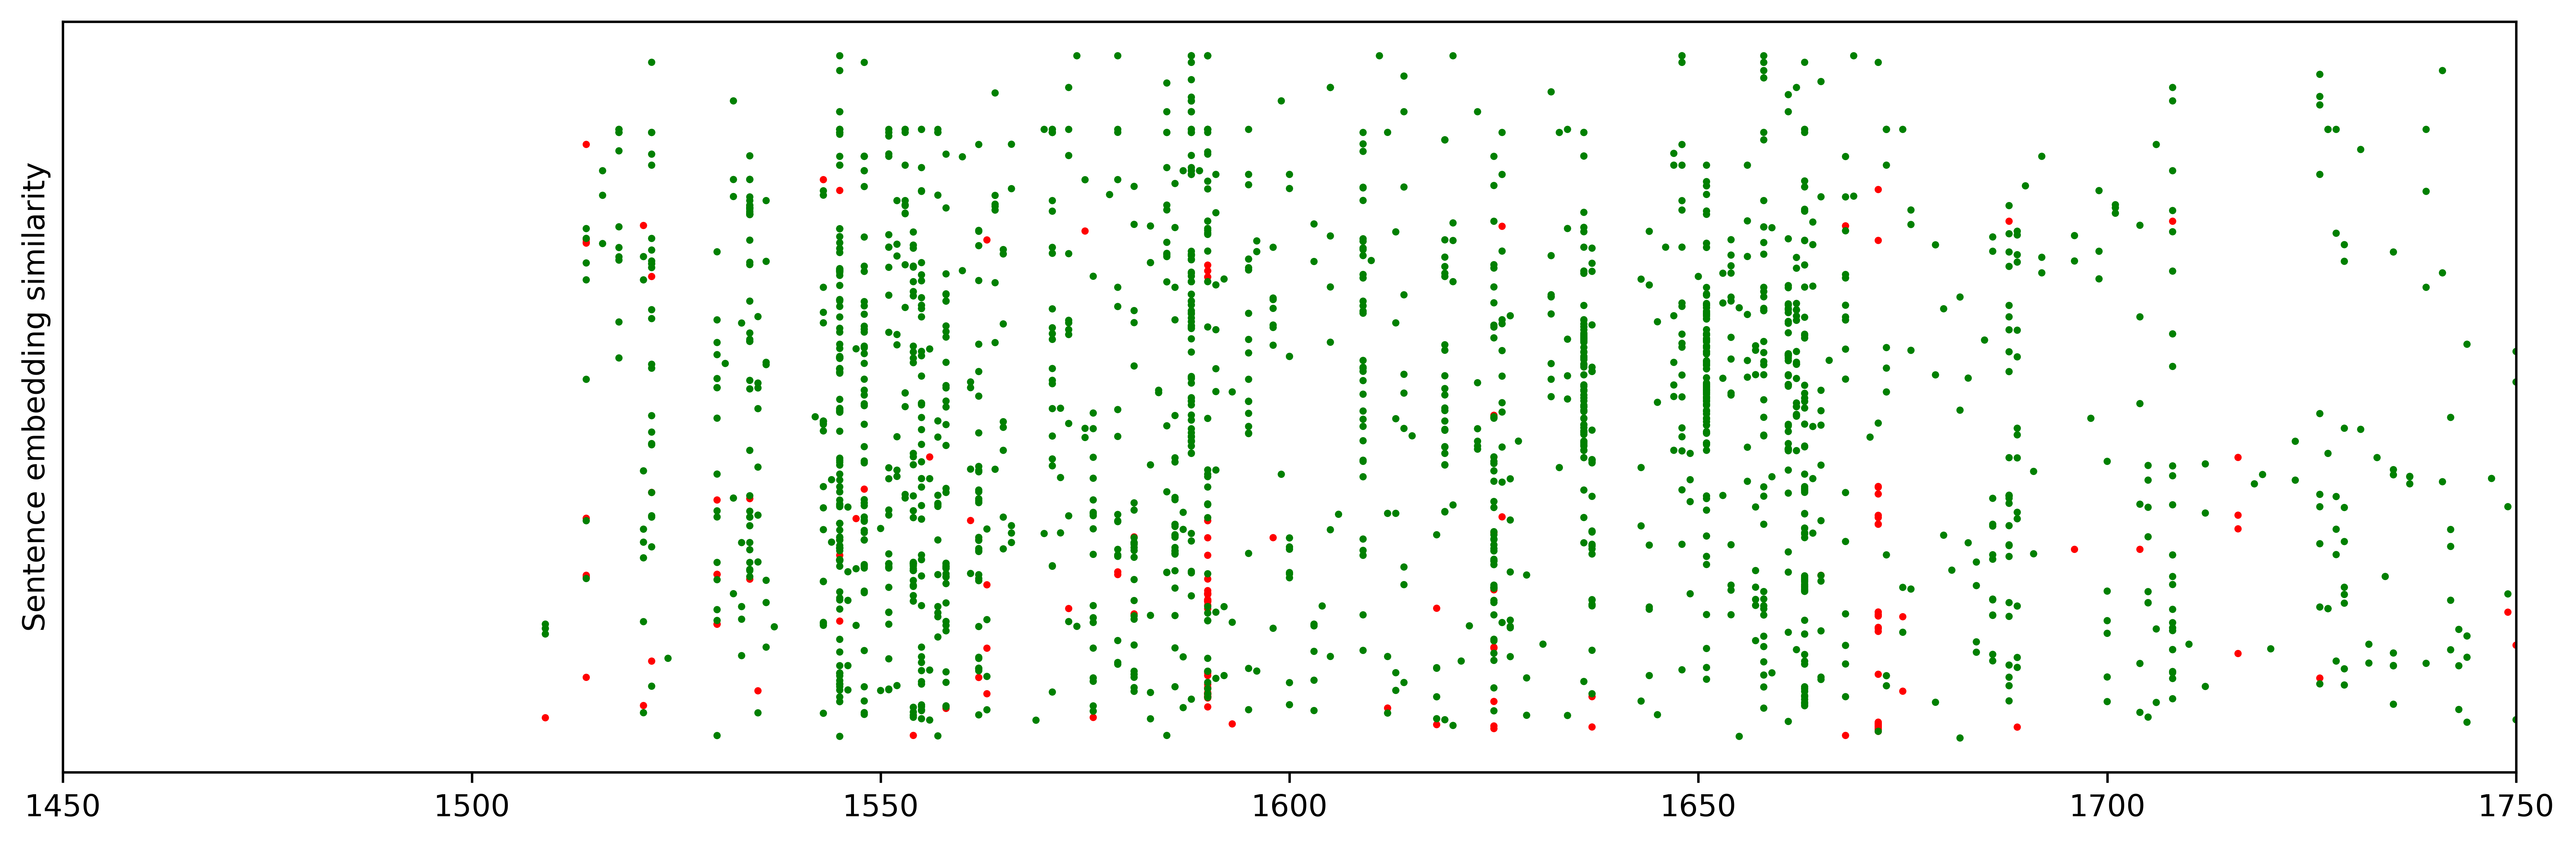

In [61]:
fig, ax = plt.subplots(tight_layout=True, dpi=600, figsize=(12,4))
ax.scatter(x=years, y=embeddings_tsne, c=colors, s=2)# You may want to adjust the size depending on your similarity matrix
ax.set_yticks([])
ax.set_ylabel("Sentence embedding similarity")
ax.set_xlim(1450, 1750)

In [62]:
xs = years
ys = [np.round(n, 2) for n in embeddings_tsne2d[:, 0]]
zs = [np.round(n, 2) for n in embeddings_tsne2d[:, 1]]

In [63]:
ys[:10]

[-15.85, 19.68, -9.19, 1.72, -3.47, -0.95, -16.81, -6.84, -35.68, 16.25]

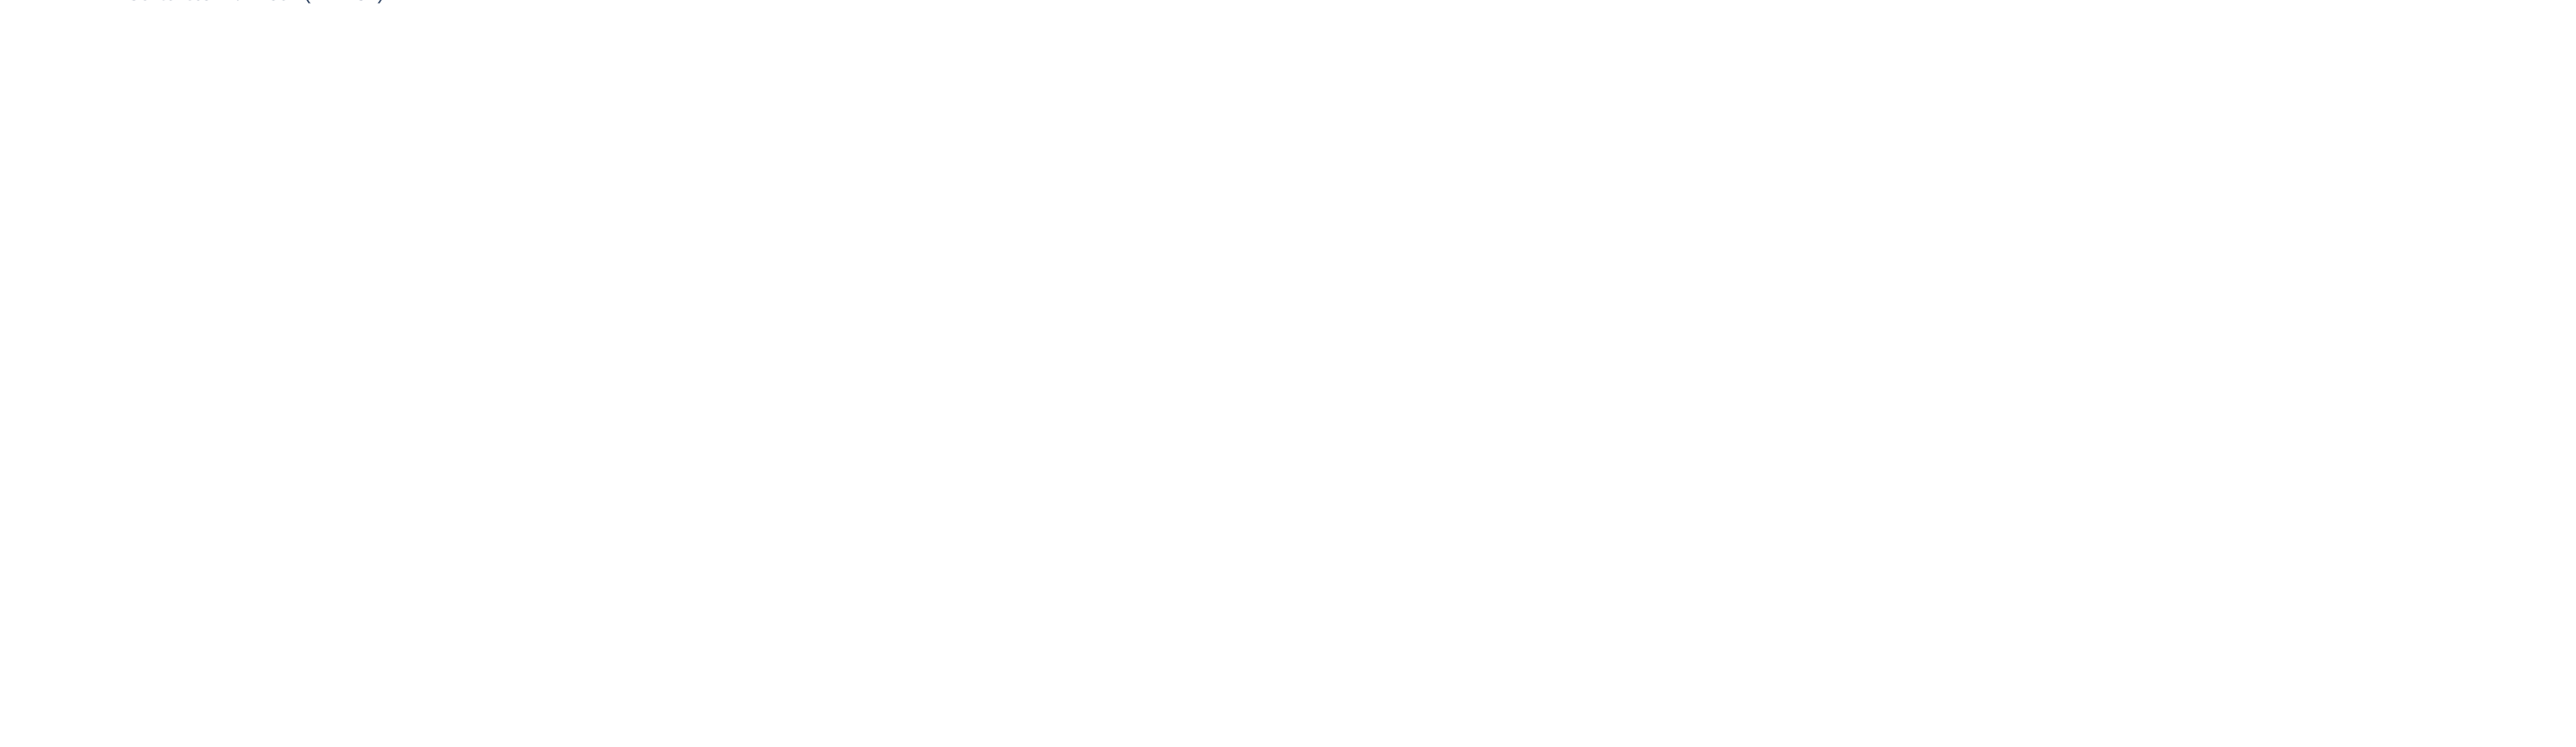

In [64]:
title = "Sentences with 'liber' (N={})".format(len(sentences))
fig = go.Figure(data=go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        size=5,
        color=colors,
        opacity=0.8
    ),
    text=hover_text,  # use mapped hover text
    hoverinfo='text',  # ensure only the text field is displayed on hover
))

fig.update_layout(
    title=title,
    scene=dict(
        xaxis=dict(title='year', showbackground=False, showgrid=True, showline=True), #showline=True, showticklabels=True, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        #xaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        yaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        zaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        bgcolor='rgba(255,255,255,0)'
    ),
    paper_bgcolor='rgba(255,255,255,255)',  # set the color of the area around the axes
    plot_bgcolor='rgba(255,255,255,255)',  # set the color of the entire chart
    autosize=False,
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=0)
)


In [111]:
pio.write_html(fig, file="../figures/liber-diachronic.html")

In [112]:
#html_code = pio.to_html(fig, include_plotlyjs='cdn')
#pyperclip.copy(html_code)

In [65]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(target_embeddings)
labels = kmeans.labels_
cluster_colors = {0: "#1f77b4",  # muted blue
                  1: "#ff7f0e",  # safety orange
                  2: "#2ca02c",  # cooked asparagus green
                  3: "#d62728",  # brick red
                  4: "#9467bd"}
# colors = [cluster_colors[l] for l in labels]

In [66]:
tsne = TSNE(n_components=3, perplexity=30)
embeddings_tsne = tsne.fit_transform(np.vstack(target_vectors))

In [67]:
xs = embeddings_tsne[:, 0]
ys = embeddings_tsne[:, 1]
zs = embeddings_tsne[:, 2]

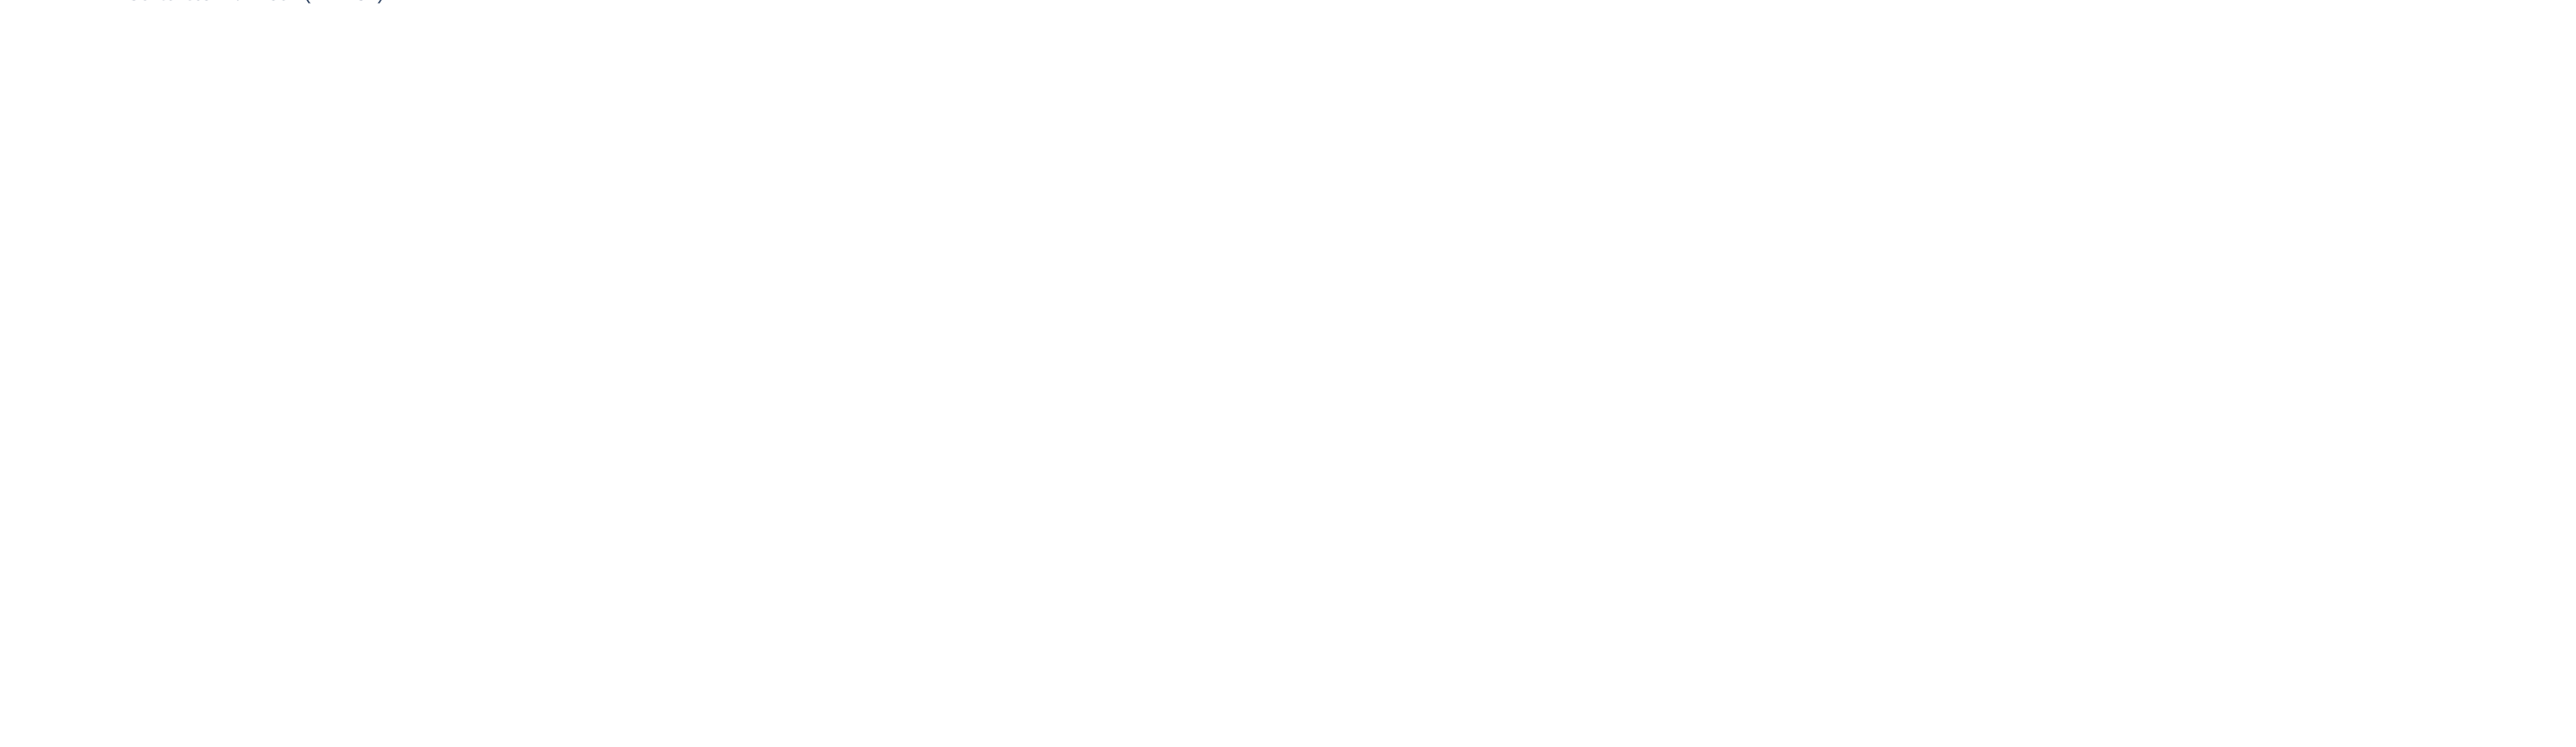

In [68]:
title = "Sentences with 'liber' (N={})".format(len(sentences))
fig = go.Figure(data=go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        size=5,
        color=colors,
        opacity=0.8
    ),
    text=hover_text,  # use mapped hover text
    hoverinfo='text',  # ensure only the text field is displayed on hover
))

fig.update_layout(
    title=title,
    scene=dict(
        xaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        yaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        zaxis=dict(title='', showgrid=False, showline=False, showticklabels=False, zeroline=False, linecolor='rgba(0,0,0,0)', showbackground=False),
        bgcolor='rgba(255,255,255,0)'
    ),
    paper_bgcolor='rgba(255,255,255,255)',  # set the color of the area around the axes
    plot_bgcolor='rgba(255,255,255,255)',  # set the color of the entire chart
    autosize=False,
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=0)
)


In [69]:
pio.write_html(fig, file="../figures/liber-sample.html")

In [70]:
#html_code = pio.to_html(fig, include_plotlyjs='cdn')
#pyperclip.copy(html_code)

In [71]:
len(sents_dfs)

2154

### Classification

In [89]:
# load back the anotated data, directly from gspread sheet
sents_meta_anot = get_as_dataframe(liber_naturae_gs.worksheet("sents_meta_df_v1"))
sents_meta_anot.head(5)

0      1                                                  2  \
0  637738    214  Argumentum affers quam obrem alteram ab altera...   
1  841475  11568  Colligit Aristoteles libro naturalium tertio s...   
2  841475  31362  Sanctaria scrinia & secretiora repositoria Pli...   
3  841475  24338                lege Senecam libro naturaliu primo.   
4  841475  55017  phantida foeminae, quam multa composuit, nomen...   

      author    year  Metaphor  Cross-reference  Internal reference  \
0  Leoniceno  1509.0     False             True               False   
1        Pio  1514.0     False             True               False   
2        Pio  1514.0     False             True               False   
3        Pio  1514.0     False             True               False   
4        Pio  1514.0     False             True               False   

   Reference to Pliny the Elder - Naturalis historia  \
0                                               True   
1                                              False   
2                                               True   
3                                              False   
4                                               True   

  Reference to another author's work  Metaphor in natural magic (chiromancy)  \
0                              False                                   False   
1                          Aristotle                                   False   
2                              False                                   False   
3                             Seneca                                   False   
4                              False                                   False   

   Metaphor in astrology/astronomy  Metaphor in natural philosophy/physics  \
0                            False                                   False   
1                            False                                   False   
2                            False                                   False   
3                            False                                   False   
4                            False                                   False   

   Metaphor in medicine or botany  \
0                           False   
1                           False   
2                           False   
3                           False   
4                           False   

   Metaphor in (philosophical) theology, encyclopaedism, or bibliography  \
0                                              False                       
1                                              False                       
2                                              False                       
3                                              False                       
4                                              False                       

   Incorrect lemma  
0            False  
1            False  
2            False  
3            False  
4            False

In [90]:
# so how many metaphors do we have?
sents_meta_anot["Metaphor"].sum()

62

In [100]:
class_data = sents_dfs[:154]  #+ random.sample(sents_dfs[154:], 346)

In [101]:
class_data[0][4]

spacy_tokens spacy_lemma spacy_pos spacy_position         bert_tokens  \
0           omnes       omnis       DET         (0, 5)            [omnes_]   
1              hi         hic       DET         (6, 8)                [hi]   
2             cum         cum       ADP        (9, 12)               [cum]   
3           lanne                  NOUN       (13, 18)          [lan, ne_]   
4               &           &     PUNCT       (19, 20)                 [&]   
5          Mambre                 PROPN       (21, 27)         [mam, bre_]   
6              et          et     CCONJ       (28, 30)                [et]   
7          Simone        Simo     PROPN       (31, 37)         [simo, ne_]   
8            mago       magus      NOUN       (38, 42)              [mago]   
9        aeternis    aeternus       ADJ       (43, 51)       [aeterni, s_]   
10        ignibus       ignis      NOUN       (52, 59)          [ignibus_]   
11      cruciandi      crucio      VERB       (60, 69)      [crucia, ndi_]   
12  destinabuntur     destino      VERB       (70, 83)  [destina, buntur_]   
13              .           .     PUNCT       (83, 84)                [._]   
14             99          99       NUM       (85, 87)                [99]   
15             In          in       ADP       (88, 90)                [in]   
16          primo      primus       ADJ       (91, 96)            [primo_]   
17          libro       liber      NOUN      (97, 102)            [libro_]   
18      naturalis   naturalis       ADJ     (103, 112)        [naturalis_]   
19          magia       magia      NOUN     (113, 118)          [magi, a_]   
20       traditur       trado      VERB     (119, 127)         [traditur_]   
21              ,           ,     PUNCT     (127, 128)                [,_]   
22           quae         qui      PRON     (129, 133)              [quae]   
23          multa      multus       DET     (134, 139)             [multa]   
24           sane        sane       ADV     (140, 144)             [sane_]   
25        cognitu    cognitus      NOUN     (145, 152)        [cognit, u_]   
26        pulchra     pulcher       ADJ     (153, 160)          [pulchra_]   
27              &           &     PUNCT     (161, 162)                 [&]   
28          iucun                   ADJ     (163, 168)          [iuc, un_]   
29             da          da       ADP     (169, 171)                [da]   
30          lectu        lego      NOUN     (172, 177)             [lectu]   
31       continet    contineo      VERB     (178, 186)         [continet_]   
32              :           :     PUNCT     (186, 187)                [:_]   

                                         bert_tok_emb  \
0   [[-0.2267545, 0.03534043, -0.57197773, -0.8987...   
1   [[0.065882646, 0.15884511, -0.29995036, -0.766...   
2   [[-0.078728326, 0.013177161, -0.32417047, -1.1...   
3   [[-0.5393002, 0.017649591, -0.66978925, -1.107...   
4   [[-0.098285615, 0.25577477, -0.37196028, -0.89...   
5   [[-0.11211276, 0.24862047, -0.40294325, -1.211...   
6   [[-0.18621594, 0.017778393, -0.23182139, -1.04...   
7   [[-0.5339989, 0.17992054, -0.07132285, -0.8835...   
8   [[-0.103658386, 0.119519696, -0.38165584, -0.6...   
9   [[-0.5825693, 0.15036915, -0.29319075, -1.0211...   
10  [[-0.2119685, -0.02800025, -0.33983883, -0.415...   
11  [[-0.40137362, -0.13304992, -0.36732808, -0.55...   
12  [[0.014151613, 0.14646553, 0.0009605256, -0.85...   
13  [[-0.21200058, -0.060892437, -0.79556954, -0.9...   
14  [[-0.16390304, 0.21782076, -0.3184218, -0.8634...   
15  [[-0.32377923, 0.13197023, -0.2877731, -1.3613...   
16  [[-0.41019115, -0.30939993, -0.41448352, -1.20...   
17  [[-0.500689, -0.06491266, -0.3863743, -0.60331...   
18  [[-0.41235715, 0.042038683, -0.13688312, -0.88...   
19  [[-0.31007752, -0.26242587, -0.21048287, -0.74...   
20  [[-0.45659456, 0.11957736, -0.10707189, -1.130...   
21  [[-0.4511241, -0.11871669, -0.27059343, -0.493...   
22  [[-0.35379595, 0.30774435, -0.2372686

In [102]:
target = "liber"
target_vectors = []
for sent_data in class_data:
    df = sent_data[4]
    target_row = df.loc[df["spacy_lemma"] == target].iloc[0]
    target_vectors.append(target_row['bert_avg_emb'])

In [104]:
### Y = 154 * [1] + 346 * [0] 

y_anotated = sents_meta_anot["Metaphor"].apply(lambda x: 1 if x else 0).tolist()
Y = y_anotated # + 346 * [0] 
Y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0]

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [107]:
len(target_vectors)

154

In [108]:
len(Y)

154

In [109]:
X_trainval, X_test, Y_trainval, Y_test = train_test_split(target_vectors, Y, test_size=0.2, random_state=42, stratify=Y)

In [110]:
# Split train into train-val
X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.2, random_state=42,
                                                  stratify=Y_trainval)

In [113]:
model = LogisticRegression(max_iter=1000) # increasing max_iter to ensure convergence
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [114]:
# Predict probabilities
Y_pred_proba = model.predict_proba(X_val)
Y_pred_proba

array([[0.49584108, 0.50415892],
       [0.44774062, 0.55225938],
       [0.97469671, 0.02530329],
       [0.01558113, 0.98441887],
       [0.28855919, 0.71144081],
       [0.58499528, 0.41500472],
       [0.91452307, 0.08547693],
       [0.38044211, 0.61955789],
       [0.18917185, 0.81082815],
       [0.07154985, 0.92845015],
       [0.26157172, 0.73842828],
       [0.92607911, 0.07392089],
       [0.85027093, 0.14972907],
       [0.05408494, 0.94591506],
       [0.92632414, 0.07367586],
       [0.72466083, 0.27533917],
       [0.99055796, 0.00944204],
       [0.4208823 , 0.5791177 ],
       [0.11520987, 0.88479013],
       [0.95689953, 0.04310047],
       [0.07463577, 0.92536423],
       [0.22153638, 0.77846362],
       [0.55196967, 0.44803033],
       [0.63374265, 0.36625735],
       [0.11348027, 0.88651973]])

In [ ]:
# Predict probabilities
Y_pred_proba = model.predict_proba(X_val)

# Get probabilities of the positive class (assuming binary classification)
Y_pred_proba_positive_class = Y_pred_proba[:, 1]

In [111]:
model = LogisticRegression(max_iter=1000) # increasing max_iter to ensure convergence
model.fit(X_train, Y_train)

Y_pred = model.predict(X_val)

print('Validation Accuracy: ', accuracy_score(Y_val, Y_pred))
print('\nClassification Report:\n', classification_report(Y_val, Y_pred))

Validation Accuracy:  0.6

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.50      0.70      0.58        10

    accuracy                           0.60        25
   macro avg       0.61      0.62      0.60        25
weighted avg       0.64      0.60      0.60        25



In [112]:
Y_pred

array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1])

In [127]:
model = LogisticRegression(max_iter=1000) # increasing max_iter to ensure convergence
model.fit(X_train, Y_train)

Y_pred = model.predict(X_val)

print('Validation Accuracy: ', accuracy_score(Y_val, Y_pred))
print('\nClassification Report:\n', classification_report(Y_val, Y_pred))

Validation Accuracy:  0.9125

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93        55
           1       0.82      0.92      0.87        25

    accuracy                           0.91        80
   macro avg       0.89      0.91      0.90        80
weighted avg       0.92      0.91      0.91        80



[Text(0, 0.5, 'liber\n(random)'), Text(0, 1.5, 'liber\nnaturae')]

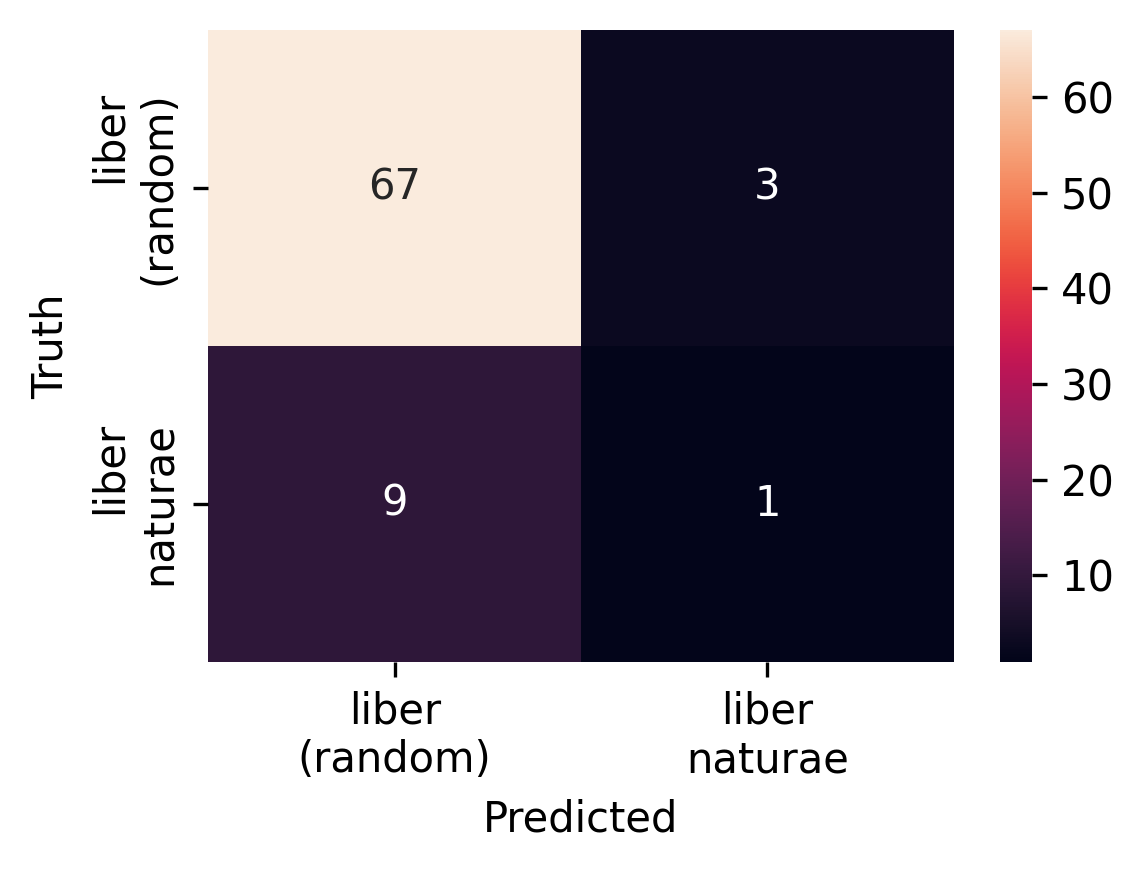

In [99]:
cm = confusion_matrix(Y_val, Y_pred)

fig, ax = plt.subplots(tight_layout=True, dpi=300, figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Truth')
ax.set_xticklabels(["liber\n(random)", "liber\nnaturae"])
ax.set_yticklabels(["liber\n(random)", "liber\nnaturae"])


[Text(0, 0.5, 'liber\n(random)'), Text(0, 1.5, 'liber\nnaturae')]

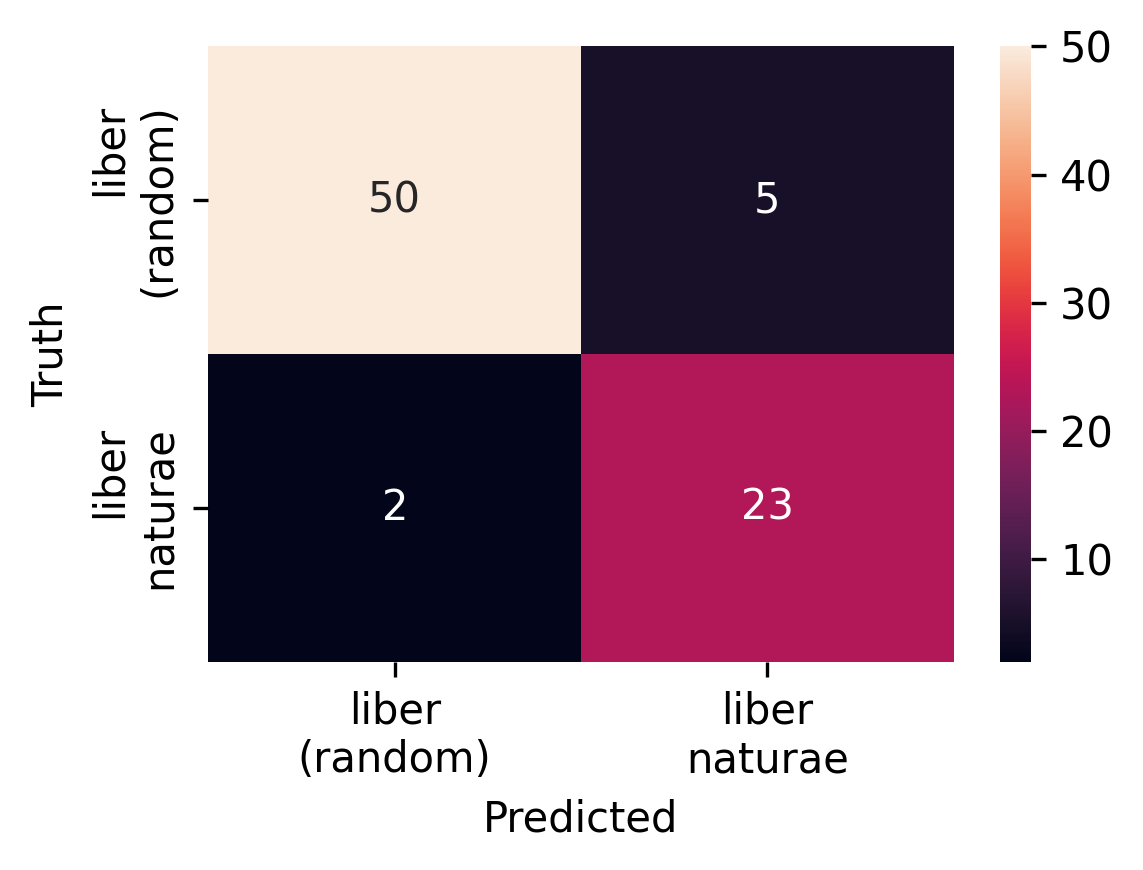

In [128]:
cm = confusion_matrix(Y_val, Y_pred)

fig, ax = plt.subplots(tight_layout=True, dpi=300, figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Truth')
ax.set_xticklabels(["liber\n(random)", "liber\nnaturae"])
ax.set_yticklabels(["liber\n(random)", "liber\nnaturae"])


In [129]:
fig.savefig("../figures/liber-confussion-matrix_v1.png")

### Loading back the annotated data

In [38]:
# load back the anotated data, directly from gspread sheet
sents_meta_anot = get_as_dataframe(liber_naturae_gs.worksheet("sents_meta_df_v1"))

In [39]:
sents_meta_anot.head(5)

0      1                                                  2  \
0  637738    214  Argumentum affers quam obrem alteram ab altera...   
1  841475  11568  Colligit Aristoteles libro naturalium tertio s...   
2  841475  31362  Sanctaria scrinia & secretiora repositoria Pli...   
3  841475  24338                lege Senecam libro naturaliu primo.   
4  841475  55017  phantida foeminae, quam multa composuit, nomen...   

      author    year  Metaphor  Cross-reference  Internal reference  \
0  Leoniceno  1509.0     False             True               False   
1        Pio  1514.0     False             True               False   
2        Pio  1514.0     False             True               False   
3        Pio  1514.0     False             True               False   
4        Pio  1514.0     False             True               False   

   Reference to Pliny the Elder - Naturalis historia  \
0                                               True   
1                                              False   
2                                               True   
3                                              False   
4                                               True   

  Reference to another author's work  Metaphor in natural magic (chiromancy)  \
0                              False                                   False   
1                          Aristotle                                   False   
2                              False                                   False   
3                             Seneca                                   False   
4                              False                                   False   

   Metaphor in astrology/astronomy  Metaphor in natural philosophy/physics  \
0                            False                                   False   
1                            False                                   False   
2                            False                                   False   
3                            False                                   False   
4                            False                                   False   

   Metaphor in medicine or botany  \
0                           False   
1                           False   
2                           False   
3                           False   
4                           False   

   Metaphor in (philosophical) theology, encyclopaedism, or bibliography  \
0                                              False                       
1                                              False                       
2                                              False                       
3                                              False                       
4                                              False                       

   Incorrect lemma  
0            False  
1            False  
2            False  
3            False  
4            False

In [41]:
len(sents_meta_anot)

154

In [40]:
# so how many metaphors do we have?
sents_meta_anot["Metaphor"].sum()

62